<div style="display: top; background-image:url('https://d1.awsstatic.com/SageMaker/SageMaker%20reInvent%202020/ImgHead_Mohave.3b1df33baa5f71b53237bfa6911fb3adc4902c0e.png');background-position: center ;background-repeat: no-repeat;background-size: 100%; padding-top:20px;">
<div style="color:#FFFFFF; text-align: top;padding-bottom: 25px; padding-left: 15px"><h1 style="font-weight: 900;">Recurrent Neural Networks (RNNs)</h1>
</div>
</div>
<br>

In this exercise, we will learn how to use Recurrent Neural Networks to classify Product Reviews as Positive or Not.

We will follow these steps:
1. <a href="#1">Reading the dataset</a>
2. <a href="#2">Exploratory data analysis</a>
3. <a href="#3">Train-validation dataset split</a>
4. <a href="#4">Text processing and transformation</a>
5. <a href="#5">Using GloVe Word Embeddings</a>
6. <a href="#6">Training and validating model</a>
7. <a href="#7">Improvement ideas</a>

Overall dataset schema:
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __log_votes:__ Logarithm-adjusted votes log(1+votes)
* __isPositive:__ Whether the review is positive or negative (1 or 0)

<div class="audun_info"><i class="fa fa-info-circle" aria-hidden="true"></i>
One big distinction betweeen the regular neural networks and RNNs is that RNNs work with sequential data. In our case, RNNs will help us with the text field. If we also want to consider other fields such as time, log_votes, verified, etc. , we need to use the regular neural networks with the RNN.
</div>

In [1]:
!pip install -q torch==1.8.1 torchtext nltk

In [2]:
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.nn import BCEWithLogitsLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

%matplotlib inline

## 1. <a name="1">Reading the dataset</a>
(<a href="#0">Go to top</a>)

Let's read the dataset below and fill-in the reviewText field. We will use this field as input to our ML model.

In [3]:
df = pd.read_csv("../../DATA/product-reviews/Amazon_Reviews_Classification.csv")

Let's look at the first five rows in the dataset.

In [4]:
df.head()

reviewText  \
0  PURCHASED FOR YOUNGSTER WHO\nINHERITED MY "TOO...   
1                              unable to open or use   
2   Waste of money!!! It wouldn't load to my system.   
3  I attempted to install this OS on two differen...   
4  I've spent 14 fruitless hours over the past tw...   

                                             summary  verified        time  \
0                                IDEAL FOR BEGINNER!      True  1361836800   
1                                          Two Stars      True  1452643200   
2                                       Dont buy it!      True  1433289600   
3  I attempted to install this OS on two differen...      True  1518912000   
4                                   Do NOT Download.      True  1441929600   

   log_votes  isPositive  
0   0.000000         1.0  
1   0.000000         0.0  
2   0.000000         0.0  
3   0.000000         0.0  
4   1.098612         0.0

## 2. <a name="2">Exploratory Data Analysis</a>
(<a href="#0">Go to top</a>)

Let's look at the range and distribution of the `isPositive` field.

In [5]:
df["isPositive"].value_counts()

1.0    43692
0.0    26308
Name: isPositive, dtype: int64

We can check the number of missing values for each columm below.

In [6]:
print(df.isna().sum())

reviewText    11
summary       14
verified       0
time           0
log_votes      0
isPositive     0
dtype: int64


We have missing values in our text fields.

## 3. <a name="3">Train-validation split</a>
(<a href="#0">Go to top</a>)

Let's split the dataset into training and validation

In [7]:
# This separates 15% of the entire dataset into validation dataset.
train_text, val_text, train_label, val_label = train_test_split(
    df["reviewText"].tolist(),
    df["isPositive"].tolist(),
    test_size=0.10,
    shuffle=True,
    random_state=324,
)

## 4. <a name="4">Text processing and Transformation</a>
(<a href="#0">Go to top</a>)

We will apply the following processes here:
* __Text cleaning:__ Simple text cleaning operations. We won't do stemming or lemmatization as our word vectors already cover different forms of words. We are using GloVe word embeddings for 6 billion words, phrases or punctuations in this example.
* __Tokenization:__ Tokenizing all sentences
* __Creating vocabulary:__ We will create a vocabulary of the tokens. In this vocabulary, tokens will map to unique ids, such as "car" &rarr; 32, "house" &rarr; 651, etc.
* __Transforming text:__ Tokenized sentences will be mapped to unique ids. For example: ["this", "is", "sentence"] &rarr; [13, 54, 412].

In [8]:
from collections import Counter
import nltk, torchtext
from nltk.tokenize import word_tokenize

nltk.download("punkt")


def cleanStr(text):

    # Check if the sentence is a missing value
    if isinstance(text, str) == False:
        text = ""

    # Remove leading/trailing whitespace
    text = text.lower().strip()
    # Remove extra space and tabs
    text = re.sub("\s+", " ", text)
    # Remove HTML tags/markups
    text = re.compile("<.*?>").sub("", text)
    return text


def tokenize(text):
    tokens = []
    text = cleanStr(text)
    words = word_tokenize(text)
    for word in words:
        tokens.append(word)
    return tokens


def createVocabulary(text_list, min_freq):
    all_tokens = []
    for sentence in text_list:
        all_tokens += tokenize(sentence)
    # Calculate token frequencies
    counter = Counter()
    for token in all_tokens:
        counter[token] += 1
    # Create the vocabulary
    vocab = torchtext.vocab.Vocab(counter, min_freq=min_freq, specials=("<unk>"))

    return vocab


def transformText(text, vocab, max_length):
    token_arr = torch.zeros((max_length,))
    tokens = tokenize(text)[0:max_length]
    for idx, token in enumerate(tokens):
        try:
            # Use the vocabulary index of the token
            token_arr[idx] = vocab.stoi[token]
        except:
            token_arr[idx] = 0  # Unknown word
    return token_arr

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In order to keep the training time low, we only consider the first 250 words (max_length) in sentences. We also only use words that occur more than 5 times in the all sentences (min_freq).

In [9]:
min_freq = 5
max_length = 250

print("Creating the vocabulary...")
vocab = createVocabulary(train_text, min_freq)

Creating the vocabulary...


In [10]:
print("Transforming training texts")
train_text_transformed = torch.stack(
    [transformText(text, vocab, max_length) for text in train_text]
)
print("Transforming validation texts")
val_text_transformed = torch.stack(
    [transformText(text, vocab, max_length) for text in val_text]
)

Transforming training texts
Transforming validation texts


Let's see some unique ids for some words.

In [11]:
print("Vocabulary index for computer:", vocab["computer"])
print("Vocabulary index for beautiful:", vocab["beautiful"])
print("Vocabulary index for code:", vocab["code"])

Vocabulary index for computer: 71
Vocabulary index for beautiful: 1933
Vocabulary index for code: 406


## 5. <a name="5">Using pre-trained GloVe Word Embeddings</a>
(<a href="#0">Go to top</a>)

In this example, we will use GloVe word vectors. `name='6B'` `dim=50` gives us 6 billion words/phrases vectors. Each word vector has 50 numbers in it. The following code shows how to get the word vectors and create an embedding matrix from them. We will connect our vocabulary indexes to the GloVe embedding with the `get_vecs_by_tokens()` function.

In [12]:
from torchtext.vocab import GloVe

glove = GloVe(name="6B", dim=50)
embedding_matrix = glove.get_vecs_by_tokens(vocab.itos)

## 6. <a name="6">Training and validation</a>
(<a href="#0">Go to top</a>)

We have processed our text data and also created our embedding matrixes from GloVe. Now, it is time to start the training process.

We will set our hyperparameters below:

In [13]:
# Size of the state vectors
hidden_size = 12

# General NN training parameters
learning_rate = 0.01
epochs = 15
batch_size = 32

# Embedding vector and vocabulary sizes
num_embed = 50  # glove.6B.50d.txt
vocab_size = len(vocab.itos)

We need to put our data into correct format before the process.

In [14]:
from torch.utils.data import TensorDataset, DataLoader

train_label = torch.tensor(train_label)
val_label = torch.tensor(val_label)
train_dataset = TensorDataset(train_text_transformed, train_label)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

Our model is made of these layers:
* Embedding layer: This is where our words/tokens are mapped to word vectors.
* RNN layer: We will be using a simple RNN model. We won't stack RNN units in this example. It uses a sinle RNN unit with its hidden state size of 12. More details about RNNs are available [here](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html).
* Linear layer: A linear layer with a single neuron is used to output our prediction for the sentiment of the review.

In [15]:
device = torch.device("cpu")  # use "cuda:0" if you are using GPU


class Net(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, num_hiddens, num_layers=num_layers)
        self.linear = nn.Linear(3000, 1)
        self.act = nn.Sigmoid()

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        outputs, _ = self.rnn(embeddings)
        outs = self.linear(outputs.reshape(outputs.shape[0], -1))
        return self.act(outs)


model = Net(vocab_size, num_embed, hidden_size)

Let's initialize this network. Then, we will need to make the embedding layer use our GloVe word vectors.

In [16]:
# We set the embedding layer's parameters from GloVe
model.embedding.weight.data.copy_(embedding_matrix)
# We won't change/train the embedding layer
model.embedding.weight.requires_grad = False

We will define the trainer and loss function below. 

__Binary cross-entropy loss__ is the correct loss function to use, as this is a binary classification problem.

$$
\mathrm{BinaryCrossEntropyLoss} = -\sum_{examples}{(y\log(p) + (1 - y)\log(1 - p))}
$$

In [17]:
# Setting our trainer
trainer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# We will use Binary Cross-entropy loss
cross_ent_loss = nn.BCEWithLogitsLoss(reduction="none")

Now, it is time to start the training process. We will print the Binary cross-entropy loss after each epoch.

In [18]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    # Training loop, train the network
    for idx, (data, target) in enumerate(train_loader):
        trainer.zero_grad()
        data = data.long().to(device)
        target = target.to(device)
        output = model(data)
        L = cross_ent_loss(output.squeeze(1), target).sum()
        training_loss += L.item()
        L.backward()
        trainer.step()

    # Calculate validation loss
    val_predictions = model(val_text_transformed.long().to(device)).squeeze(1)
    val_loss = cross_ent_loss(val_predictions, val_label).sum().item()

    # Let's take the average losses
    training_loss = training_loss / len(train_label)
    val_loss = val_loss / len(val_label)

    train_losses.append(training_loss)
    val_losses.append(val_loss)

    end = time.time()
    print(
        f"Epoch {epoch}. Train_loss {training_loss:.3f}. Validation_loss {val_loss:.3f}. Seconds {(end-start):.2f}"
    )

Epoch 0. Train_loss 0.627. Validation_loss 0.603. Seconds 10.56
Epoch 1. Train_loss 0.597. Validation_loss 0.580. Seconds 11.25
Epoch 2. Train_loss 0.586. Validation_loss 0.580. Seconds 12.77
Epoch 3. Train_loss 0.580. Validation_loss 0.576. Seconds 19.00
Epoch 4. Train_loss 0.575. Validation_loss 0.575. Seconds 19.87
Epoch 5. Train_loss 0.571. Validation_loss 0.570. Seconds 20.21
Epoch 6. Train_loss 0.567. Validation_loss 0.567. Seconds 17.88
Epoch 7. Train_loss 0.564. Validation_loss 0.565. Seconds 23.06
Epoch 8. Train_loss 0.561. Validation_loss 0.564. Seconds 87.85
Epoch 9. Train_loss 0.560. Validation_loss 0.564. Seconds 104.39
Epoch 10. Train_loss 0.559. Validation_loss 0.564. Seconds 98.79
Epoch 11. Train_loss 0.557. Validation_loss 0.563. Seconds 33.89
Epoch 12. Train_loss 0.556. Validation_loss 0.564. Seconds 19.41
Epoch 13. Train_loss 0.554. Validation_loss 0.563. Seconds 26.50
Epoch 14. Train_loss 0.553. Validation_loss 0.563. Seconds 24.41


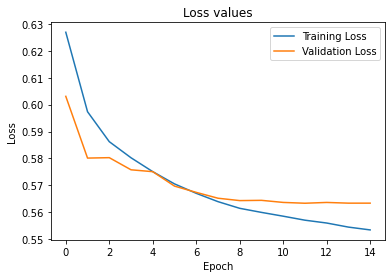

In [19]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Let's see some validation results below:

In [20]:
# Get validation predictions
val_predictions = model(val_text_transformed.to(device).long())

# Round predictions: 1 if pred>0.5, 0 otherwise
val_predictions = np.round(val_predictions.detach().numpy())

print("Classification Report")
print(classification_report(val_label.numpy(), val_predictions))
print("Accuracy")
print(accuracy_score(val_label.numpy(), val_predictions))

Classification Report
              precision    recall  f1-score   support

         0.0       0.66      0.76      0.71      2605
         1.0       0.84      0.77      0.81      4395

    accuracy                           0.77      7000
   macro avg       0.75      0.76      0.76      7000
weighted avg       0.78      0.77      0.77      7000

Accuracy
0.7664285714285715


In [21]:
# Styling notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()